# CPSC 4810 - Group project




***
# Project description

This project’s objective is to put in practice some of the techniques and methods learned throughout the term about doing data wrangling and analysis with python coding. Some of the tools used were Pandas and Matplotlib. The different files came from various source and formats: CSV files, TXT files, an API, and we even practiced some web-scraping! 

The first step of the project was to choose the topic. We decided to use data related to movies, actors, and movie awards. The reason behind this decision is that as avid fans of the 7th art, we wanted to learn more about it. Although there might be more ‘relevant’ industries like pharmaceutics, food, logistics, or education, the entertaining industry can be equally as big and profitable. Moreover, we wanted to analyze data with which we are acquainted and in which the insights are comprehensible.

With our topic defined, the team embarked on the task to pick different datasets with useful information. More details about each of the datasets chosen, as well as the usage given to each is provided through this project.

***
# Data

For this project 7 datasets from 4 different sources were used:
1.	Credits – CSV file obtained from Kaggle.
2.	Keywords – CSV file obtained from Kaggle.
3.	Movies – CSV file obtained from Kaggle.
4.	Ratings – CSV file obtained from Kaggle.
5.	Academy Award Winning Films – data from a table [Wikipedia](https://en.wikipedia.org/wiki/List_of_Academy_Award-winning_films). 
6.	Top Movies – Rest API from [OMDb API](https://www.omdbapi.com/).
7.	Oscar Winners – TXT file from [OpenIntro.org](OpenIntro.org)

More information about the content of each dataset as well as how they were used is provided through the rest of this document.

***
# Sources

![alt text](datasources.png "Sources")

***
# Importing libraries

In [1]:
import pandas as pd

Because we will be dealing with JSON strings, we import json:

In [2]:
import json
from os.path import exists

***
# Dataset 1: Credits

## Description

The original dataset was obtained from Kaggle: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset and contains 3 columns:

- **Cast** – information in JSON format about the cast that participated in the movie.
- **Crew** – information in JSON format about the crew the helped to create the movie.
- **ID** – integer that uniquely identifies each movie. 

## Transformation and cleaning

The original file (**credits_cleaned01**) is larger than 100mb, which makes it quite heavy, however some data cleaning might help us make the file more manageable. 


**!!!! RUN THIS CODE ONLY IF YOU HAVE THE credits_cleaned01.csv FILE !!!!**

The ***credits_cleaned01.csv*** file is greater than 100mb, so it cannot be upload to GitHub. Skip this part and run the section where the file **credits_cleaned03.csv** is imported.


Because we are not interested in the column with the **crew** information it will be deleted:

In [3]:
file_exists = exists("data/credits_cleaned01.csv")
if(file_exists):
    credits = pd.read_csv('data/credits_cleaned01.csv')
    credits.drop(columns=['crew'], inplace=True, axis=1)
    credits.to_csv('data/credits_cleaned02.csv', index=False)
    display(list(credits.columns))

['Unnamed: 0', 'cast', 'id']

We read the new file and display its size and columns. We can see there are only two columns: 

In [4]:
file_exists = exists("data/credits_cleaned02.csv")
if(file_exists):
    credits = pd.read_csv('data/credits_cleaned02.csv',index_col=0)
    display(len(credits))
    display(list(credits.columns))

45399

['cast', 'id']

Each row in the **cast** column contains a large JSON with information we don't want to use. This is how each **cast** looks like:

In [5]:
if(file_exists):
    print(credits.iloc[0]['cast'][0:500],"...")

[{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}, {'cast_id': 15, 'character': 'Buzz Lightyear (voice)', 'credit_id': '52fe4284c3a36847f8024f99', 'gender': 2, 'id': 12898, 'name': 'Tim Allen', 'order': 1, 'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'}, {'cast_id': 16, 'character': 'Mr. Potato Head (voice)', 'credit_id': '52fe4284c3a36847f8024f9d' ...


Since the format of the JSON is not compatible with **json.loads()** we need to change the structure to have a dictionary of people for each movie:
- Create function to clean JSON
- Loop through each row on the dataset
- Change quotes to dummy values
- Remove unnecessary quotes or backslash (if any)
- Remove unnecessary indexes from the dict of people (cast_id, credit_id, gender, etc...)
- Update the dataset with the reduced JSON file (the dataset won't have unnecessary keys anymore)

In [6]:
def cleanjsontring (jsonSting):
        jsonSting = jsonSting.replace("{'", "{##")
        jsonSting = jsonSting.replace('{"', "{##")

        jsonSting = jsonSting.replace("': ", "##: ")
        jsonSting = jsonSting.replace('": ', "##: ")

        jsonSting = jsonSting.replace(", '", ", ##")
        jsonSting = jsonSting.replace(', "', ", ##")

        jsonSting = jsonSting.replace("'}", "##}")
        jsonSting = jsonSting.replace('"}', "##}")

        jsonSting = jsonSting.replace(": '", ": ##")
        jsonSting = jsonSting.replace("', ", "##, ")
        jsonSting = jsonSting.replace(': "', ': ##')
        jsonSting = jsonSting.replace('", ', '##, ')
        jsonSting = jsonSting.replace('"}', '##}')
        jsonSting = jsonSting.replace("\\", '')

        jsonSting = jsonSting.replace('"', "")
        jsonSting = jsonSting.replace("'", "")

        jsonSting = jsonSting.replace('##', '"')
        jsonSting = jsonSting.replace(": None", ": null")
        return jsonSting

In [7]:
file_exists = exists("data/credits_cleaned02.csv")
if(file_exists):
    credits = pd.read_csv('data/credits_cleaned02.csv',index_col=0)
    credits.reset_index(drop=True, inplace=True)

errors = []
if(file_exists):
    for i, credit in credits.iterrows():
        if(i >= 0):
            try:
                cast = cleanjsontring(credit.cast)
                
                if(credit.cast == "[]" or credit.cast == ""):
                    errors.append(i)
                else:
                    arrayOfPeople = json.loads(cast)
                    for dictOfPeople in arrayOfPeople:
                        dictOfPeople.pop("cast_id")
                        dictOfPeople.pop("credit_id")
                        dictOfPeople.pop("gender")
                        dictOfPeople.pop("order")
                        dictOfPeople.pop("profile_path")
                        dictOfPeople.pop("id")
                        dictOfPeople['character'].replace('"',"´")
                    credits.iloc[i,0] = json.dumps(arrayOfPeople)
            except Exception as e:
                print(i)
                errors.append(i)
print(credits[credits["id"]==238])

                                                  cast   id
834  [{"character": "Don Vito Corleone", "name": "M...  238


In [8]:
#These are out of range elements:
#print(errors)

In [9]:
len(credits)

45399

An error could appear when transforming the json string into an object, this happens if the json string is not valid.

If we want to eliminate errors we run the following code:

In [10]:
for i in errors:
    try:
        credits.drop(credits.index[i],inplace=True)
    except Exception as e:
        #print(e)
        pass
credits.reset_index(drop=True, inplace=True)

In [11]:
len(credits)

43182

In [12]:
credits.head(5)

,cast,id
0,"[{""character"": ""Woody (voice)"", ""name"": ""Tom H...",862
1,"[{""character"": ""Alan Parrish"", ""name"": ""Robin ...",8844
2,"[{""character"": ""Max Goldman"", ""name"": ""Walter ...",15602
3,"[{""character"": ""Savannah Vannah Jackson"", ""nam...",31357
4,"[{""character"": ""George Banks"", ""name"": ""Steve ...",11862


Now we store this dataframe as a new file. With these steps we have reduced the original file from 190mb to 37mb, which is better because we will deal with a smaller file:

In [13]:
credits.to_csv('data/credits_cleaned03.csv')

## Usage

In [14]:
credits = pd.read_csv('data/credits_cleaned03.csv', index_col=0)
credits.head(5)

,cast,id
0,"[{""character"": ""Woody (voice)"", ""name"": ""Tom H...",862
1,"[{""character"": ""Alan Parrish"", ""name"": ""Robin ...",8844
2,"[{""character"": ""Max Goldman"", ""name"": ""Walter ...",15602
3,"[{""character"": ""Savannah Vannah Jackson"", ""nam...",31357
4,"[{""character"": ""George Banks"", ""name"": ""Steve ...",11862


Let's get a dataset of performers counting their participation on movies:

In [15]:
actArray = []
movArray = []

for i, credit in credits.iterrows():
    try:
        arrayOfPeople = json.loads(credit.cast)
        for dictOfPeople in arrayOfPeople:
            actArray.append(dictOfPeople["name"])
            movArray.append(credit.id)
            #if(credit.id == 238):
                #print(".......")
                #print(dictOfPeople)
                #print(credit.id)
                #print(dictOfPeople["name"])
                #print(".....")
    except Exception as e:  
        print(i,credit.cast,e)
        break

    
myDict = {'performer': actArray, 'movie_id': movArray}
acts = pd.DataFrame(data=myDict)

#for i in range(0,len(performer_counts)):
    #print(performer_counts.iloc[i].performer, performer_counts.iloc[i].number_of_movies)
    #break

performer_counts = acts.groupby([acts['performer']]).count()['movie_id'].sort_values(ascending=False).to_frame()
performer_counts.columns = performer_counts.columns.str.replace('movie_id', 'movies')
display(performer_counts.head(10))

,movies
performer,
Bess Flowers,230
Christopher Lee,141
John Wayne,120
Samuel L. Jackson,120
Donald Sutherland,107
Jackie Chan,104
Gérard Depardieu,104
John Carradine,103
Frank Welker,103


***
# Dataset 2: Keywords

## Description

This dataset was also obtained from Kaggle: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset and it contains 2 columns:

- **ID** – Integer that uniquely identifies each movie. 
- **Keywords** – A list of different words that might be used to look for a movie. All of these words are in JSON format.


## Transformation and cleaning

Because of the simplicity of the file, no cleaning was needed.

## Usage

In [16]:
keywords = pd.read_csv('data/keywords.csv')
keywords.head(5)

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


***
# Dataset 3: Movies

## Description


This dataset was also obtained from Kaggle: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset and it contains 24 columns:

1.	Adult
2.	belongs_to_collection
3.	Budget 
4.	Genres
5.	Homepage 
6.	ID 
7.	imdb_id 
8.	original_language 
9.	original_title  
10.	overview 
11.	popularity
12.	poster_path
13.	production_companies
14.	production_countries
15.	release_date
16.	revenue
17.	runtime
18.	spoken_languages
19.	status
20.	tagline
21.	title
22.	video
23.	vote_average
24.	vote_count

In [17]:
movies = pd.read_csv('data/movies_metadata.csv',dtype={'popularity': 'float'})
print('Columns:')
print(',  '.join(movies))

Columns:
adult,  belongs_to_collection,  budget,  genres,  homepage,  id,  imdb_id,  original_language,  original_title,  overview,  popularity,  poster_path,  production_companies,  production_countries,  release_date,  revenue,  runtime,  spoken_languages,  status,  tagline,  title,  video,  vote_average,  vote_count


In [18]:
movies.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173



## Transformation and cleaning


The following 3 variables were cleaned:

- **belongs_to_collection** – Column with data in JSON format. It contains information about the ‘saga’ or ‘series’ of the movie.
- **genres** – Data in JSON format containing the different genres that the movie can catalogued in.
- **production_companies** – Data in JSON format containing the different companies that took part

Cleaning column **belongs_to_collection**:

In [19]:
print(movies.loc[:,'belongs_to_collection'][0])
print(movies.loc[:,'belongs_to_collection'][9])

{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}
{'id': 645, 'name': 'James Bond Collection', 'poster_path': '/HORpg5CSkmeQlAolx3bKMrKgfi.jpg', 'backdrop_path': '/6VcVl48kNKvdXOZfJPdarlUGOsk.jpg'}


The column has some values that we are not going to use: poster_path, backdrop_path and id.

In [20]:
errors = []
for i, movie in movies.iterrows():
    if(i >= 0):
        try:
            collection = cleanjsontring(movie.belongs_to_collection)

            if(movie.belongs_to_collection == "[]" or movie.belongs_to_collection == ""):
                errors.append(i)
            else:
                collectionDict = json.loads(collection)
                #Removing the columns poster_path, backdrop_path, and id
                collectionDict.pop("poster_path")
                collectionDict.pop("backdrop_path")
                collectionDict.pop("id")
                movies.loc[i,'belongs_to_collection'] = json.dumps(collectionDict)
                #movies.loc[i,'belongs_to_collection'] = str(collectionDict['name'])
        except Exception as e:
            #print(e)
            errors.append(i)

Clean output:

In [21]:
movies.loc[:,'belongs_to_collection'][0]

'{"name": "Toy Story Collection"}'

Cleaning column **genres**:

In [22]:
print(movies.loc[:,'genres'][0])
print(movies.loc[:,'genres'][9])

[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]
[{'id': 12, 'name': 'Adventure'}, {'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


The column has some values that we are not going to use: id

In [23]:
errors = []
for i, movie in movies.iterrows():
    if(i >= 0):
        try:
            genres = cleanjsontring(movie.genres)

            if(movie.genres == "[]" or movie.genres == ""):
                errors.append(i)
            else:
                genresDict = json.loads(genres)
                for genre in genresDict:
                    #Removing the column id
                    genre.pop("id")
                movies.loc[i,'genres'] = json.dumps(genresDict)
        except Exception as e:
            #print(e)
            errors.append(i)

Clean output:

In [24]:
print(movies.loc[:,'genres'][0])

[{"name": "Animation"}, {"name": "Comedy"}, {"name": "Family"}]


Cleaning column **production_companies**:

In [25]:
movies.loc[:,'production_companies'][1]

"[{'name': 'TriStar Pictures', 'id': 559}, {'name': 'Teitler Film', 'id': 2550}, {'name': 'Interscope Communications', 'id': 10201}]"

The column has some values that we are not going to use: id

In [26]:
errors = []
for i, movie in movies.iterrows():
    if(i >= 0):
        try:
            prod_companies = cleanjsontring(movie.production_companies)
            if(movie.production_companies == "[]" or movie.production_companies == ""):
                errors.append(i)
            else:
                prodcompDict = json.loads(prod_companies)
                for prodcomp in prodcompDict:
                    #Removing the column id
                    prodcomp.pop("id")
                movies.loc[i,'production_companies'] = json.dumps(prodcompDict)
        except Exception as e:
            #print(e)
            errors.append(i)

Clean output:

In [27]:
movies.loc[:,'production_companies'][1]

'[{"name": "TriStar Pictures"}, {"name": "Teitler Film"}, {"name": "Interscope Communications"}]'

Exporting the changes to a new file:

In [28]:
movies.to_csv('data/movies_cleaned01.csv', index=False)

## Usage

In [29]:
movies = pd.read_csv('data/movies_cleaned01.csv', dtype={'popularity': 'float'})
print('Columns:')
print(',  '.join(movies))

Columns:
adult,  belongs_to_collection,  budget,  genres,  homepage,  id,  imdb_id,  original_language,  original_title,  overview,  popularity,  poster_path,  production_companies,  production_countries,  release_date,  revenue,  runtime,  spoken_languages,  status,  tagline,  title,  video,  vote_average,  vote_count


List the top 10 movies with the greatest revenue

In [30]:
top10movies=movies['revenue'].sort_values(ascending=False).head(10)
#Filter the rows with the index of the previous request and show some columns (two of them are formatted for best reading)
movies.iloc[top10movies.index].loc[:,['original_title','release_date','budget','revenue']]. \
style.format({"budget": "{:,d}", "revenue": "{:,d}"})

,original_title,release_date,budget,revenue
14551,Avatar,2009-12-10,"237,000,000","2,787,965,087"
26554,Star Wars: The Force Awakens,2015-12-15,"245,000,000","2,068,223,624"
1639,Titanic,1997-11-18,"200,000,000","1,845,034,188"
17818,The Avengers,2012-04-25,"220,000,000","1,519,557,910"
25083,Jurassic World,2015-06-09,"150,000,000","1,513,528,810"
28829,Furious 7,2015-04-01,"190,000,000","1,506,249,360"
26557,Avengers: Age of Ultron,2015-04-22,"280,000,000","1,405,403,694"
17437,Harry Potter and the Deathly Hallows: Part 2,2011-07-07,"125,000,000","1,342,000,000"
22109,Frozen,2013-11-27,"150,000,000","1,274,219,009"
42219,Beauty and the Beast,2017-03-16,"160,000,000","1,262,886,337"


List the top 10 movies with the greatest losses

In [31]:
#Create a new column as net_income
movies['net_income'] = movies['revenue'] - movies['budget']
#Obtain the lowest 10 values of the column revenue (do not include movies that have a revenue zero)
top10movies=movies[movies.revenue!=0]['net_income'].sort_values().head(10)
#Filter the rows with the index of the previous request and show some columns
movies.iloc[top10movies.index].loc[:,['original_title','release_date','budget','revenue','net_income']]. \
style.format({"budget": "{:,d}", "revenue": "{:,d}", "net_income": "{:,d}"})

,original_title,release_date,budget,revenue,net_income
21174,The Lone Ranger,2013-07-03,"255,000,000","89,289,910","-165,710,090"
7226,The Alamo,2004-04-07,"145,000,000","25,819,961","-119,180,039"
16788,Mars Needs Moms,2011-03-09,"150,000,000","38,992,758","-111,007,242"
44334,Valerian and the City of a Thousand Planets,2017-07-20,"197,471,676","90,024,292","-107,447,384"
2711,The 13th Warrior,1999-08-27,"160,000,000","61,698,899","-98,301,101"
5389,The Adventures of Pluto Nash,2002-08-15,"100,000,000","7,103,973","-92,896,027"
1901,Metropolis,1927-01-10,"92,620,000","650,422","-91,969,578"
14,Cutthroat Island,1995-12-22,"98,000,000","10,017,322","-87,982,678"
41488,Live by Night,2016-12-25,"108,000,000","22,678,555","-85,321,445"
11376,Flushed Away,2006-10-22,"149,000,000","64,459,316","-84,540,684"


Working with the movies collection

In [32]:
colecArray = []
for i, movie in movies.iterrows():
    try:
        if str(movie.belongs_to_collection) == 'nan':
            colecArray.append(None)
        else:
            collectionList = json.loads(movie.belongs_to_collection)
            colecArray.append(collectionList["name"])
    except Exception as e:  
       print(i,movie.belongs_to_collection,e)
       break

myDict = {'collection': colecArray}
collections = pd.DataFrame(data=myDict)
collections['movie']=movies['original_title']
collections['release_date']=movies['release_date']

collections.dropna(inplace=True)

In [33]:
#Function creation to obtain the movies and their collection
def obtain_collections (movie):
    return collections[collections['movie'].str.lower().str.contains(movie)]

In [34]:
obtain_collections ('star wars')

,collection,movie,release_date
256,Star Wars Collection,Star Wars,1977-05-25
2514,Star Wars Collection,Star Wars: Episode I - The Phantom Menace,1999-05-19
5244,Star Wars Collection,Star Wars: Episode II - Attack of the Clones,2002-05-15
10069,Star Wars Collection,Star Wars: Episode III - Revenge of the Sith,2005-05-17
26554,Star Wars Collection,Star Wars: The Force Awakens,2015-12-15
30902,Robot Chicken: Star Wars Collection,Robot Chicken: Star Wars,2007-07-17
41486,Star Wars Collection,Rogue One: A Star Wars Story,2016-12-14


### Movies and keywords per decade

Create a new column with the numerical value of the year, we well need this value in order to filter the dataframe by year, the code and print out below show the old column release_date with the new column year:


In [35]:
movies["year"] = movies["release_date"].str.slice(stop=4).astype('Int64')
movies[["release_date","year"]]

,release_date,year
0,1995-10-30,1995
1,1995-12-15,1995
2,1995-12-22,1995
3,1995-12-22,1995
4,1995-02-10,1995
...,...,...
45458,NaN,<NA>
45459,2011-11-17,2011
45460,2003-08-01,2003
45461,1917-10-21,1917


We will now get the count of the most repeated keywords on each decade and display the top keywords.

What are we doing here?
- First we create list of 6 dictionaries
- Each dictionary includes a list of movie idd
    - For example in the first dictionary (1970-1979 decade) the list of movies [103, 11, 5879, 51242, 1011...]
    - Those Ids are the id of a movie released in that decade
- Once we have the list of movies ids, we loop through this list 
- For every movie we find the list of keywords
- We add the keyword into the list of keywords per decade
- Count the most used keywords

We are trying to see if the keywords are different decade to decade:

In [36]:
decades = [
    {"1970-1979": movies[(movies["year"]>=1970) & (movies["year"]<=1979)]["id"].tolist()},
    {"1980-1989": movies[(movies["year"]>=1980) & (movies["year"]<=1989)]["id"].tolist()},
    {"1990-1999": movies[(movies["year"]>=1990) & (movies["year"]<=1999)]["id"].tolist()},
    {"2000-2009": movies[(movies["year"]>=2000) & (movies["year"]<=2009)]["id"].tolist()},
    {"2010-2019": movies[(movies["year"]>=2010) & (movies["year"]<=2019)]["id"].tolist()},
    {"2020-2022": movies[(movies["year"]>=2020) & (movies["year"]<=2022)]["id"].tolist()}
]

print("These are the most used keywords per decade:")
print()
for i in range(len(decades)):
    listOfKeywords = []
    for years, ids in decades[i].items():
        print("---------------------------------------------")
        print(years)
        print("---------------------------------------------")
        for movieId in ids:
            filteredDF = keywords[keywords["id"] == movieId]
            if(len(filteredDF.index) != 0):
                myString = filteredDF.iloc[0]['keywords']
                myJson = json.loads(cleanjsontring(myString))
                for myKeyword in myJson:
                    listOfKeywords.append(myKeyword["name"])
    
    print(pd.Series(listOfKeywords).value_counts().head(6).to_string())
    print()
    print()

These are the most used keywords per decade:

---------------------------------------------
1970-1979
---------------------------------------------
murder              164
female nudity       140
independent film    133
nudity              129
sex                 103
based on novel       97


---------------------------------------------
1980-1989
---------------------------------------------
independent film    201
murder              190
nudity              145
woman director      134
female nudity       127
violence             98


---------------------------------------------
1990-1999
---------------------------------------------
woman director      396
independent film    362
murder              190
sex                 118
violence            109
nudity              106


---------------------------------------------
2000-2009
---------------------------------------------
woman director          988
independent film        948
murder                  251
sex                     

 ### Results
- The keyword **murder** appears in every decade in the top 5 but as decade by decade, the keyword is less present in the movies.
- **Sex** is present in the 70, 80, 90 decade but not after that (considerably).
- **Woman director** was gaining popularity decade by decade.

***
# Dataset 4: Academy Award winning films

## Description

This dataset was obtained from Wikipedia: https://en.wikipedia.org/wiki/List_of_Academy_Award-winning_films. It contains four columns:

- **Film** – The name of the movie.
- **Year** – Year of publication.
- **Awards** – Number of awards received.
- **Nominations** – Number of award nominations .


## Transformation and cleaning

The dataset is already clean.

## Usage

We will get the list of academy award winning films from Wikipedia by performing web scraping data. We will use it to compare the best movies with what we have in our other datasets.

In [37]:
import requests
from bs4 import BeautifulSoup
url = "https://en.wikipedia.org/wiki/List_of_Academy_Award-winning_films"
req = requests.get(url)
soup = BeautifulSoup(req.content, 'html.parser')
body = soup.find('body')
table = body.find('table')
tbody = table.find('tbody')


c_names = []
awardsData = []

trs = tbody.findAll('tr')
for i in range(len(trs)):
    
    if(i ==0):
        #Getting column names:
        ths = trs[i].findAll('th')
        for j in range(len(ths)):
            c_names.append(ths[j].getText().replace(u'\n', ''))
    else:
        #Data:
        tds = trs[i].findAll('td')
        awardsData.append({
            c_names[0]:tds[0].getText(),
            c_names[1]:tds[1].getText().replace(u'\xa0', ''),
            c_names[2]:int(tds[2].getText().split(' ')[0].replace(u'\n', '')),
            c_names[3]:int(tds[3].getText().split('[')[0].replace(u'\n', '')),
        });
        
academyAwards = pd.DataFrame.from_dict(sorted(awardsData, key=lambda d: d['Nominations'], reverse=True) )

In [38]:
display(academyAwards.head(10))

,Film,Year,Awards,Nominations
0,La La Land,2016,6,14
1,Titanic,1997,11,14
2,All About Eve,1950,6,14
3,The Shape of Water,2017,4,13
4,The Curious Case of Benjamin Button,2008,3,13
5,Chicago,2002,6,13
6,The Lord of the Rings: The Fellowship of the Ring,2001,4,13
7,Shakespeare in Love,1998,7,13
8,Forrest Gump,1994,6,13
9,Who's Afraid of Virginia Woolf?,1966,5,13


Boxplot of Nominations


<AxesSubplot:>

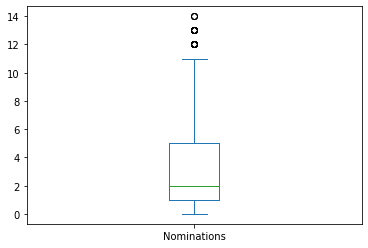

In [49]:
import matplotlib as plt 
#box plot Nominations
print("Boxplot of Nominations")
academyAwards['Nominations'].plot.box()

Boxplot of Awards


<AxesSubplot:>

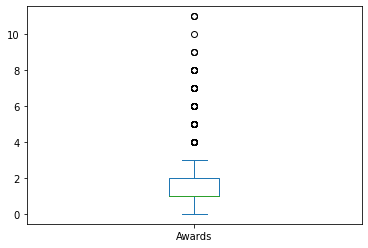

In [51]:
#box plot Awards
print("Boxplot of Awards")
academyAwards['Awards'].plot.box()

<AxesSubplot:xlabel='Awards', ylabel='Nominations'>

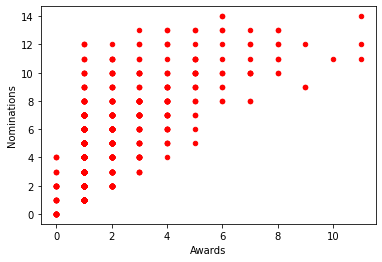

In [55]:
#Looking for Correlation
academyAwards.plot(kind = 'scatter',
        x = 'Awards',
        y = 'Nominations',
        color = 'red')

***
# Dataset 5: Top Movies (OMDb API)

## Description

OMDb-API provides an API where we can get information about films.

## Usage

We want to compare the the information from Wikipedia with the information provided by the API.

In order to do this, we are using the module requests passing the apiKey and it returns a JSON.

In [56]:
#from PIL import Image
from io import BytesIO

awardsFromApiData = []

for i in range(len(academyAwards.head(10))):
    url = "http://www.omdbapi.com/?apikey=1161cf29&t="+academyAwards.iloc[i]["Film"]
    req = requests.get(url)
    MovieData = req.json()
    #img = requests.get(MovieData["Poster"])
    #img = Image.open(BytesIO(img.content))
    #img.thumbnail((200, 200))
    #display(img)
    awardsFromApiData.append({
        "Title" : MovieData["Title"],
        "Director" : MovieData["Director"],
        "APIAwards" : MovieData["Awards"],
        "imdbID" : MovieData["imdbID"],
    })

Here we see the API shows more nominations than Wikipedia but the Awards are basically the same.

In [57]:
pd.concat([
    academyAwards.head(10),
    pd.DataFrame(data=awardsFromApiData)["APIAwards"]
], axis=1)

,Film,Year,Awards,Nominations,APIAwards
0,La La Land,2016,6,14,Won 6 Oscars. 243 wins & 297 nominations total
1,Titanic,1997,11,14,Won 11 Oscars. 125 wins & 83 nominations total
2,All About Eve,1950,6,14,Won 6 Oscars. 27 wins & 20 nominations total
3,The Shape of Water,2017,4,13,Won 4 Oscars. 138 wins & 358 nominations total
4,The Curious Case of Benjamin Button,2008,3,13,Won 3 Oscars. 83 wins & 160 nominations total
5,Chicago,2002,6,13,Won 6 Oscars. 57 wins & 129 nominations total
6,The Lord of the Rings: The Fellowship of the Ring,2001,4,13,Won 4 Oscars. 121 wins & 126 nominations total
7,Shakespeare in Love,1998,7,13,Won 7 Oscars. 64 wins & 87 nominations total
8,Forrest Gump,1994,6,13,Won 6 Oscars. 51 wins & 75 nominations total
9,Who's Afraid of Virginia Woolf?,1966,5,13,Won 5 Oscars. 22 wins & 28 nominations total


Now we would like to get the movies with more nominations / Awards and see if the performes who have been in more movies also are in the best movies.

Histogram of vote count < 100 (since there are movies with up to 14000 votes )


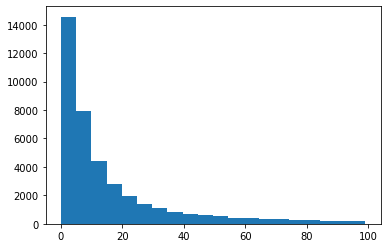

In [58]:
import matplotlib
import matplotlib.pyplot as plt
print("Histogram of vote count < 100 (since there are movies with up to 14000 votes )")
plt.hist(movies[movies["vote_count"]<100]["vote_count"], bins=20)
plt.show()

There are so many movies with less than 100 votes, in order to get the most popular movies we'll use the movies with more than 100 votes ordered by the average (in english)

In [59]:
top_movies = movies[(movies["vote_count"]>100) & (movies["original_language"] == "en")].sort_values(by=['vote_average'],ascending=False)[["original_title","id"]].reset_index(drop=True)
top_movies.head(15)

,original_title,id
0,Planet Earth,192040
1,The Godfather,238
2,The Shawshank Redemption,278
3,Dear Zachary: A Letter to a Son About His Father,15584
4,The Dark Knight,155
5,In a Heartbeat,455661
6,The Godfather: Part II,240
7,Psycho,539
8,Once Upon a Time in America,311
9,Fight Club,550


No people in movie ID: 238
No people in movie ID: 455661

In average, every performer is present in  2.73 movies
The histogram below shows that most performers have worked in 1 to 4 movies


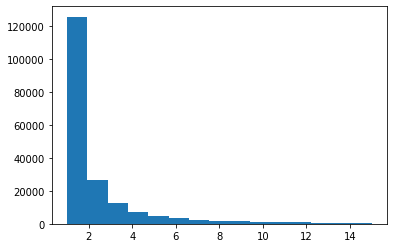

The next top ten list shows the average of movies of the performers 


,original_title,id,movies_top_tree_x,movies_top_tree_y
0,Planet Earth,192040,10.0,10.0
2,The Shawshank Redemption,278,43.8,43.8
3,Dear Zachary: A Letter to a Son About His Father,15584,1.0,1.0
4,The Dark Knight,155,54.2,54.2
6,The Godfather: Part II,240,56.4,56.4
7,Psycho,539,30.5,30.5
8,Once Upon a Time in America,311,47.5,47.5
9,Fight Club,550,29.3,29.3
10,Black Mirror: White Christmas,374430,9.5,9.5
11,Schindler's List,424,37.1,37.1


In [60]:
movies_id = []
performers_per_movie_and_movies = []
index=0
found=0
while found < 10:
    movies_id.append(top_movies.iloc[index]["id"])
    try:
        list_of_performers = acts[acts["movie_id"] == top_movies.iloc[index]["id"]][["performer"]].values.tolist()
        performer_per_movie_and_movies = []

        for performer in list_of_performers:
            performer_per_movie_and_movies.append({"performer":performer[0], "movies":performer_counts.loc[performer[0]].values[0]})

        performer_per_movie_and_movies=pd.DataFrame(performer_per_movie_and_movies).sort_values(by="movies", ascending=False)

        performers_per_movie_and_movies.append(performer_per_movie_and_movies.head(10)["movies"].mean())
        found = found + 1
    except Exception as e:
        print("No people in movie ID:", top_movies.iloc[index]["id"])
        performers_per_movie_and_movies.append(0)
        #continue
    index = index + 1

print("")
print("In average, every performer is present in ", round(performer_counts["movies"].mean(),2), "movies")

print("The histogram below shows that most performers have worked in 1 to 4 movies")
plt.hist(performer_counts[performer_counts["movies"]<=15]["movies"], bins=15)
plt.show()


top_movies["movies_top_tree"] = pd.Series(performers_per_movie_and_movies)
print("The next top ten list shows the average of movies of the performers ")



top_ten_movies = pd.merge(
    top_movies, 
    pd.DataFrame(zip(movies_id, performers_per_movie_and_movies),columns =['id', 'movies_top_tree']), 
    on=['id','id'], 
    how='outer'
)

top_ten_movies=top_ten_movies[top_ten_movies["movies_top_tree_x"]>0].head(10)
top_ten_movies

In [61]:
print("For example the movie Fight Club has this list of performes with the amount of movies each one:")
list_of_performers = acts[acts["movie_id"] == 550].values.tolist()
performer_per_movie_and_movies = []

for performer in list_of_performers:
    performer_per_movie_and_movies.append({"performer":performer[0], "movies":performer_counts.loc[performer[0]].values[0]})
(performer_per_movie_and_movies)


performer_per_movie_and_movies=pd.DataFrame(performer_per_movie_and_movies)
display(performer_per_movie_and_movies.sort_values(by="movies", ascending=False).head(10))

print("The mean of movies of the top 10 performers of this movie is: ", performer_per_movie_and_movies.sort_values(by="movies", ascending=False).head(10)["movies"].mean())

For example the movie Fight Club has this list of performes with the amount of movies each one:


,performer,movies
1,Brad Pitt,58
4,Helena Bonham Carter,56
0,Edward Norton,29
2,Meat Loaf,29
6,Holt McCallany,25
3,Jared Leto,24
5,Zach Grenier,21
18,Matt Winston,17
27,Michael Shamus Wiles,17
9,David Andrews,17


The mean of movies of the top 10 performers of this movie is:  29.3


***
# Dataset 7: Oscar Winners (TXT file)

## Description

This dataset is obtained from the TXT file in the following URL: https://www.openintro.org/data/tab-delimited/oscars.txt. It contains the following variables. Only the ones in **bold** were taken.

- _oscar_no_  
- **oscar_yr** - Year in which the Oscar was awarded.
- **award** - Award for best actor or actress.
- **name** - Name of the actor.
- **movie** - Name of the movie.
- **age** - Age of the actor at the time of receiving the award.
- **birth_pl** - Birthplace of the actor.
- **birth_date** - Birthdate of the actor.
- _birth_mo_
- _birth_d_
- _birth_y_

## Usage

In [62]:
import requests
url = 'https://www.openintro.org/data/tab-delimited/oscars.txt'
req = requests.get(url, headers={"User-Agent": "Notebook"})
#Create a list with the TXT results and use the \n to separate the rows
Oscar_list=req.text.split('\n')
Oscar_data=[]
for i,row in enumerate(Oscar_list):
    if i==0:
        col_names=row.split('\t')
    else:
        Oscar_data.append(row.split('\t'))
#Creation of the dataframe
Oscars=pd.DataFrame(Oscar_data, columns=col_names)
#Remove of the last row
Oscars.drop(index=Oscars.index[-1], axis=0, inplace=True)
#Removal of unnecessary columns
Oscars.drop(columns=['oscar_no', 'birth_mo','birth_d', 'birth_y'], inplace=True)
display(Oscars)

,oscar_yr,award,name,movie,age,birth_pl,birth_date
0,1929,Best actress,Janet Gaynor,7th Heaven,22,Pennsylvania,1906-10-06
1,1930,Best actress,Mary Pickford,Coquette,37,Canada,1892-04-08
2,1931,Best actress,Norma Shearer,The Divorcee,28,Canada,1902-08-10
3,1932,Best actress,Marie Dressler,Min and Bill,63,Canada,1868-11-09
4,1933,Best actress,Helen Hayes,The Sin of Madelon Claudet,32,Washington DC,1900-10-10
...,...,...,...,...,...,...,...
179,2015,Best actor,Eddie Redmayne,The Theory of Everything,32,England,1982-01-06
180,2016,Best actor,Leonardo Di Caprio,The Revenant,41,California,1974-11-11
181,2017,Best actor,Casey Affleck,Manchester by the Sa,41,Massachusetts,1975-08-12
182,2018,Best actor,Gary Oldman,Darkest Hour,59,England,1958-03-21


List of actors/actresses that were awarded more than 1 Oscar.

In [63]:
top10actors = Oscars['name'].value_counts()
top10actors = top10actors[top10actors.values>1]
top10actors

Katharine Hepburn      4
Daniel Day-Lewis       3
Sally Field            2
Olivia de Havilland    2
Meryl Streep           2
Jack Nicholson         2
Frances McDormand      2
Jane Fonda             2
Glenda Jackson         2
Hilary Swank           2
Tom Hanks              2
Sean Penn              2
Jodie Foster           2
Fredric March          2
Dustin Hoffman         2
Ingrid Bergman         2
Marlon Brando          2
Vivien Leigh           2
Luise Rainer           2
Bette Davis            2
Gary Cooper            2
Spencer Tracy          2
Name: name, dtype: int64

In which movies did the best actor/actress Oscar awards take place?

In [64]:
index=[]
for i,name in enumerate(Oscars['name']):
    if name in top10actors.index:
        index.append(i)
Oscars.iloc[index]
grouped=Oscars.iloc[index]
grouped=grouped.loc[:,['name','movie','oscar_yr','award']].groupby(['name','movie'])
grouped.first().sort_values(['name','oscar_yr'])

oscar_yr  \
name                movie                                                  
Bette Davis         Dangerous                                       1936   
                    Jezebel                                         1939   
Daniel Day-Lewis    My Left Foot                                    1990   
                    There Will Be Blood                             2008   
                    Lincoln                                         2013   
Dustin Hoffman      Kramer vs. Kramer                               1980   
                    Rain Man                                        1989   
Frances McDormand   Fargo                                           1997   
                    Three Billboards Outside of Ebbing Missouri     2018   
Fredric March       Dr. Jekyll and Mr. Hyde                         1933   
                    The Best Years of Our Lives                     1947   
Gary Cooper         Sergeant York                                   1942   
                    High Noon                                       1953   
Glenda Jackson      Women In Love                                   1971   
                    A Touch of Class                                1974   
Hilary Swank        Boys Don't Cry                                  2000   
                    Million Dollar Baby                             2005   
Ingrid Bergman      Gaslight                                        1945   
                    Anastasia                                       1957   
Jack Nicholson      One Flew Over The Cuckoo's Nes                  1976   
                    As Good as It Gets                              1998   
Jane Fonda          Klute                                           1972   
                    Coming Home                                     1979   
Jodie Foster        The Accused                                     1989   
                    The Silence of the Lambs                        1992   
Katharine Hepburn   Morning Glory                                   1934   
                    Guess Who's Coming to Dinner                    1968   
                    The Lion in Winter                              1969   
                    On Golden Pond                                  1982   
Luise Rainer        The Great Zeigfeld                              1937   
                    The Good Earth                                  1938   
Marlon Brando       On The Waterfront                               1955   
                    The Godfather                                   1973   
Meryl Streep        Sophies Choice                                  1983   
                    The Iron Lady                                   2012   
Olivia de Havilland To Each His Own                                 1947   
                    The Heiress                                     1950   
Sally Field         Norma Rae                                       1980   
                    Places in the Heart                             1985   
Sean Penn           Mystic River                                    2004   
                    Milk                                            2009   
Spencer Tracy       Captains Courageous                             1938   
                    Boys Town                                       1939   
Tom Hanks           Philadelphia                                    1994   
                    Forest Gump                                     1995   
Vivien Leigh        Gone With the Wind                              1940   
                    A Streetcar Named Desire                        1952   

                                                                        award  
name                movie                                                      
Bette Davis         Dangerous                                    Best actress  
                    Jezebel                                      Best actress  
Daniel Day-Lewis   

List of movies that won the award of best actor and best actress.

In [65]:
movies_2_oscars=Oscars['movie'].value_counts()
movies_2_oscars=movies_2_oscars[movies_2_oscars.values==2]
movies_2_oscars

Network                     2
Coming Home                 2
It Happened One Night       2
On Golden Pond              2
The Silence of the Lambs    2
Name: movie, dtype: int64

Which actor and actress was awarded the Oscar:

In [66]:
index=[]
for i,movie in enumerate(Oscars['movie']):
    if movie in movies_2_oscars.index:
        index.append(i)
Oscars.iloc[index].sort_values('oscar_yr')[['oscar_yr','award','name','movie']]

,oscar_yr,award,name,movie
6,1935,Best actress,Claudette Colbert,It Happened One Night
92,1935,Best actor,Clark Gable,It Happened One Night
49,1977,Best actress,Faye Dunaway,Network
134,1977,Best actor,Peter Finch,Network
51,1979,Best actress,Jane Fonda,Coming Home
136,1979,Best actor,Jon Voight,Coming Home
54,1982,Best actress,Katharine Hepburn,On Golden Pond
139,1982,Best actor,Henry Fonda,On Golden Pond
64,1992,Best actress,Jodie Foster,The Silence of the Lambs
149,1992,Best actor,Anthony Hopkins,The Silence of the Lambs
